<a href="https://colab.research.google.com/github/BeatriceZbj/CompetitionData/blob/main/Data_Compeitition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_data_randomf.csv to test_data_randomf.csv
Saving test_for_submissions.csv to test_for_submissions.csv
Saving train updated 04132022.csv to train updated 04132022.csv
Saving train_data_randomf.csv to train_data_randomf.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

In [ ]:
class DataPreprocess:

    'processing the data'

    def __init__(self, filename):
        if filename.split('.')[-1] == 'csv':
            data = pd.read_csv(filename)
        else:
            data = pd.read_excel(filename)
        self.data = data.drop_duplicates()
    
    def missing_data(self):
        explore = self.data.describe().T
        explore['null'] = len(self.data)-explore['count'] 
        explore = explore.loc[:,('null', 'max', 'min')]
        explore.columns = ['Missing Number', 'Max', 'Min']
        explore['Missing Ratio'] = explore['Missing Number']/len(self.data)
        
        explore2 = self.data.describe(include='object').T  
        explore2['null'] = len(self.data) - explore2['count']
        explore2['Missing Ratio'] = explore2['null']/len(self.data)
        
        explore3 = self.data.describe(include='bool').T  
        explore3['null'] = len(self.data) - explore3['count']
        explore3['Missing Ratio'] = explore3['null']/len(self.data)
        return explore, explore2, explore3


    def feature_engneering(self):
        try:
            X = self.data.drop(['deviceid','fail_7'],axis = 1)
        except:
            X = self.data.drop(['deviceid'],axis = 1)
        X['Periods'] = (pd.to_datetime(X['LastRecord']) - pd.to_datetime(X['Date Deployed'])).map(lambda x:x.days)
        X.drop(['LastRecord','Date Deployed'], axis = 1, inplace = True)
        lbl = preprocessing.LabelEncoder()
        X['charge_cycle_time_below_12'] = lbl.fit_transform(X['charge_cycle_time_below_12'])
        return X


    def fill_miss_byRandomForest(self, data_df, obj_column, missing_other_column):
        data_left = data_df[missing_other_column]
        data_df = data_df.drop(missing_other_column , axis = 1)
        known = data_df[data_df[obj_column].notnull()]
        unknown = data_df[data_df[obj_column].isnull()]
        y_know = known[obj_column]
        X_know= known.drop(obj_column , axis = 1)

        rfr = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=3, n_jobs=-1)
        rfr.fit(X_know,y_know)
        X_unknow= unknown.drop(obj_column , axis = 1)
        predicted = rfr.predict(X_unknow).round(3)
        data_df.loc[(data_df[obj_column].isnull()), obj_column] = predicted
        data_df = pd.concat([data_df,data_left], axis = 1)
        return data_df

In [ ]:
train_result = DataPreprocess('/content/train updated 04132022.csv')

In [ ]:
test_result = DataPreprocess('/content/test_for_submissions.csv')

In [ ]:
x, y, z = train_result.missing_data()
data = train_result.feature_engneering()

In [ ]:
x1, y1, z1 = test_result.missing_data()
data1 = test_result.feature_engneering()

In [ ]:
names = x[x['Missing Number']>0].index.tolist()
for i in range(len(names)):
    col = names.pop()
    print(i)
    data = train_result.fill_miss_byRandomForest(data, col, names)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [ ]:
data.to_csv('train_data_randomf.csv')

In [ ]:
names1 = x1[x1['Missing Number']>0].index.tolist()
for i in range(len(names1)):
    col = names1.pop()
    print(i)
    data1 = test_result.fill_miss_byRandomForest(data1, col, names1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [ ]:
data1.to_csv('test_data_randomf.csv')

分成训练集和验证集

In [ ]:
data = pd.read_csv('/content/train_data_randomf.csv')

In [ ]:
data = data.drop('Unnamed: 0', axis = 1)

In [ ]:
X = data.copy()
y = pd.read_csv('/content/train updated 04132022.csv')['fail_7']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
SMO= SMOTE(random_state=1234) 
over_samples_x_train,over_samples_y_train = SMO.fit_resample(X_train, y_train)

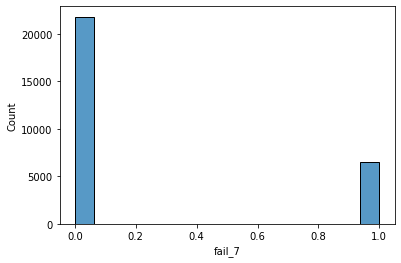

In [ ]:
sns.histplot(y_train)

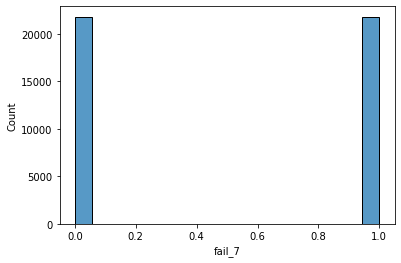

In [ ]:
sns.histplot(over_samples_y_train)

模型训练一： KNN模型

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_std  = ss.fit_transform(over_samples_x_train)
X_val_std = ss.transform(X_val)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import neighbors

# knn = neighbors.KNeighborsClassifier(n_neighbors=10)   
# best_model = knn.fit(over_samples_x, over_samples_y) 
# predict_proba = best_model.predict_proba(over_samples_x) 
k = np.arange(2,30,1)
auc1 = []
auc2 = []
for i in k:

    knn = neighbors.KNeighborsClassifier(n_neighbors=i)   
    best_model = knn.fit(X_std, over_samples_y_train) 
    predict_train_proba = best_model.predict_proba(X_std) 
    false_positive_rate_1, true_positive_rate_1, thresholds = roc_curve(over_samples_y_train, predict_train_proba[:,1])
    roc_auc_1 = auc(false_positive_rate_1, true_positive_rate_1)
    auc1.append(roc_auc_1)

    predict_val_proba = best_model.predict_proba(X_test_std) 
    false_positive_rate_2, true_positive_rate_2, thresholds = roc_curve(y_val, predict_val_proba[:,1])
    roc_auc_2 = auc(false_positive_rate_2, true_positive_rate_2)
    auc2.append(roc_auc_2)


KeyboardInterrupt: ignored

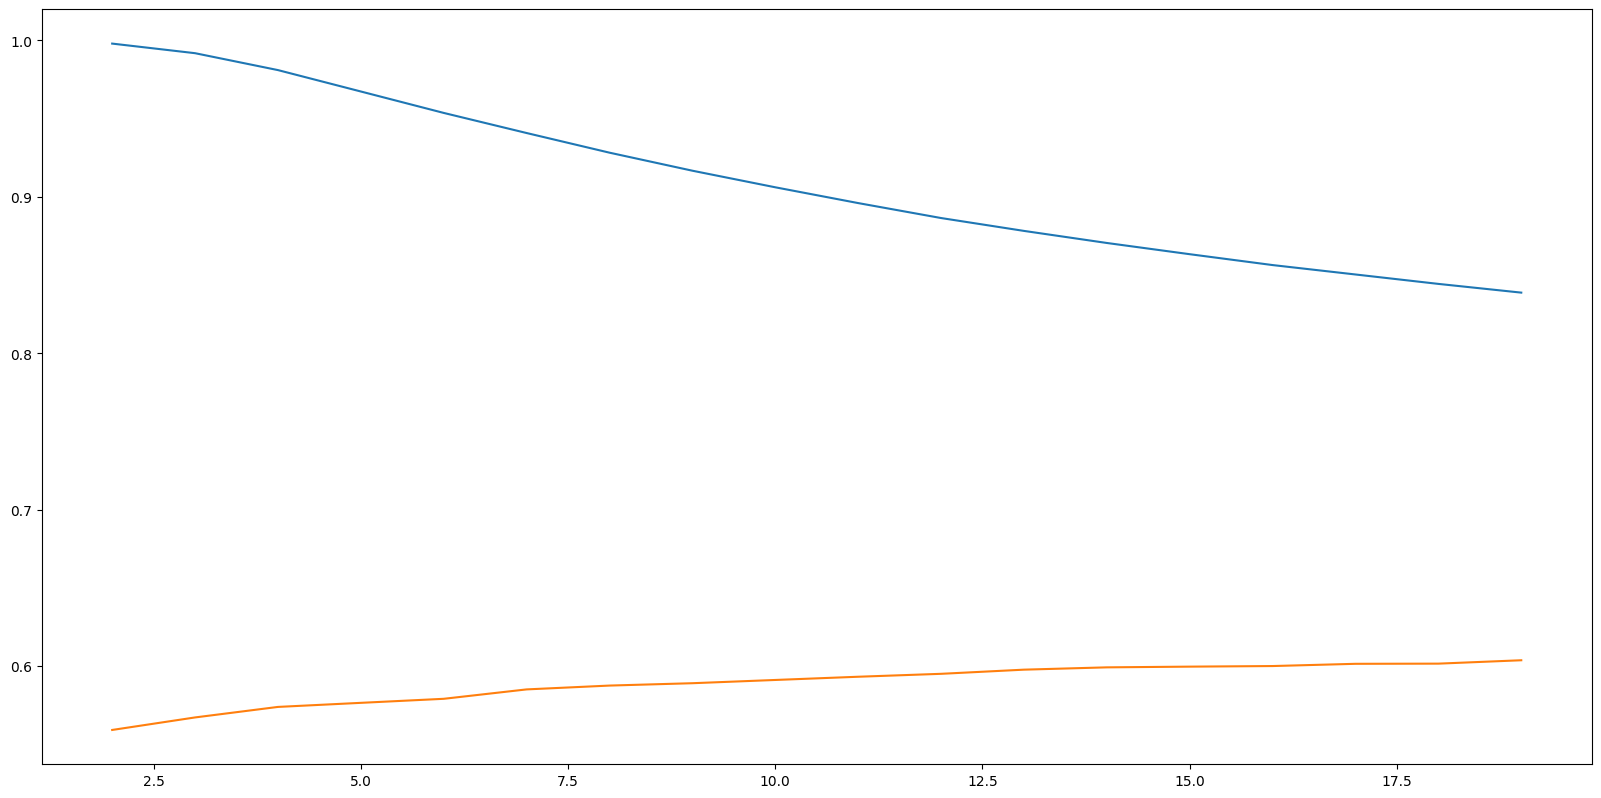

In [ ]:
plt.figure(figsize=(20,10), dpi=100)
plt.plot(k, auc1)
plt.plot(k, auc2)
# 很明显的过拟合 k=3还行

用网格搜索交叉验证的方式对KNN进行优化

In [ ]:

params = {'weights':['uniform','distance'],'n_neighbors': range(2,20,1)}
knn = neighbors.KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid = params, cv=10, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_std, over_samples_y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 20),
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [ ]:
# 使用 GridSearchCV 进行参数优化
parameters = {
            'n_neighbors':range(2,30,4),
            'weights':['uniform','distance'],
            'p':[1,2]
            }
knn = neighbors.KNeighborsClassifier(algorithm = 'kd_tree')
grid_search = GridSearchCV(knn, parameters, scoring='roc_auc',cv=5)
grid_search.fit(X_std,over_samples_y_train) 

grid_search.best_estimator_   #查看函数（最优评估）
grid_search.best_score_       #正确率 (accuracy)
grid_search.best_params_      #最佳组合（参数）

{'n_neighbors': 7, 'weights': 'distance'}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score, params)

0.8416940976404998 {'n_neighbors': 2, 'weights': 'uniform'}
0.8480916000750301 {'n_neighbors': 2, 'weights': 'distance'}
0.8574450198280402 {'n_neighbors': 3, 'weights': 'uniform'}
0.8749302235739969 {'n_neighbors': 3, 'weights': 'distance'}
0.8597332181229745 {'n_neighbors': 4, 'weights': 'uniform'}
0.8898742500741905 {'n_neighbors': 4, 'weights': 'distance'}
0.8559393231571206 {'n_neighbors': 5, 'weights': 'uniform'}
0.8985060428186078 {'n_neighbors': 5, 'weights': 'distance'}
0.8478768812415975 {'n_neighbors': 6, 'weights': 'uniform'}
0.9019975891177306 {'n_neighbors': 6, 'weights': 'distance'}
0.8386326206688777 {'n_neighbors': 7, 'weights': 'uniform'}
0.9029297542930262 {'n_neighbors': 7, 'weights': 'distance'}
0.8299612723329549 {'n_neighbors': 8, 'weights': 'uniform'}
0.9018325908239266 {'n_neighbors': 8, 'weights': 'distance'}
0.8203428532978446 {'n_neighbors': 9, 'weights': 'uniform'}
0.8984874231922584 {'n_neighbors': 9, 'weights': 'distance'}
0.8123840992906299 {'n_neighbors

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2, weights='uniform')
knn.fit(X_std, over_samples_y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
knn.score(X_val_std, y_val)

0.6386831275720165

In [ ]:
predicted = knn.predict(X_val_std)

In [ ]:
print(metrics.classification_report(y_val, predicted))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      9311
           1       0.29      0.36      0.32      2839

    accuracy                           0.64     12150
   macro avg       0.54      0.54      0.54     12150
weighted avg       0.67      0.64      0.65     12150



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def Euclidean_distance(point1, point2): #计算两个点之间的欧几里得距离
    return np.sqrt(np.sum((point1 - point2) ** 2))

def get_Euclidean_distance(point, dataSet): # 得到一个点到数据集里面所有点的距离
    distanceSet = []
    for sample in dataSet:
        if Euclidean_distance(point, sample): # 排除这个点本身，即排除与自己距离为0的点
            distanceSet.append(Euclidean_distance(point, sample))
    return distanceSet

class KNN(): # k近邻算法
    k = 0
    def train(self, x_train, y_train): # train函数得到最好的k值，即以周围多少个点进行投票效果最好
        Kmax = 11 # k最大为点的个数
        best_k = 0 # 初始化最好的k
        best_accurrcy = 0 # 初始化最好的k对应的准确度
        for k in range(1, Kmax): # 依次计算每一个k
            labelSet = self.predict(x_train, k) # 计算当前k下各点的label
            count = np.sum(np.logical_xor(labelSet, y_train) == 1) # 预测结果与真实标记不一致就说明预测失败
            precision = 1 - count / y_train.shape[0] # 计算在训练集上的准确度
            print("k = %2d accurrcy: %.2f" % (k, precision))
            if precision > best_accurrcy: # 记录最好的k
                best_accurrcy = precision
                best_k = k
        return best_k, best_accurrcy

    
    def predict(self, predictSet, k):
        labelSet = []
        for point in predictSet:
            distanceSet = get_Euclidean_distance(point, x_train) # 得到当前点与训练集所有点的距离
            sorted_index = sorted(range(len(distanceSet)), key=lambda k: distanceSet[k], reverse=False) # 得到距离从小到大排序的索引
            count1 = list(y_train[sorted_index[:k]]).count(1) # 计算前k个最近的点的label个数，进行投票
            count0 = list(y_train[sorted_index[:k]]).count(0)
            if count0 < count1:
                labelSet.append(1) # 哪个数字多，当前点的label就是哪个数字
            else:
                labelSet.append(0)
        return labelSet

def plot_desicion_boundary(X, y, knn): # 画出决策边界
    x_min = np.array(X)[:, 0].min() - 0.1 # 计算图的边界
    x_max = np.array(X)[:, 0].max() + 0.1
    y_min = np.array(X)[:, 1].min() - 0.1
    y_max = np.array(X)[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = knn.predict(np.vstack([xx.ravel(), yy.ravel()]).T.tolist(), knn.k)
    Z = np.array(Z).reshape(xx.shape)
    f, axarr = plt.subplots(1, 1, figsize=(10, 8))
    axarr.contourf(xx, yy, Z, alpha = 0.4)
    axarr.scatter(np.array(X)[:, 0], np.array(X)[:, 1], c=y, s=10, edgecolor='k')
    axarr.set_title("KNN (k={})".format(1))
    plt.savefig("k={}.png".format(1))
    plt.show()

# print('load data...')
# path = os.path.abspath(os.path.dirname(__file__)) # 获取py文件当前路径
# x_train = np.loadtxt(path + "/30alpha.csv", delimiter=",", usecols=(0, 1))
# y_train = np.loadtxt(path + "/30alpha.csv", delimiter=",", usecols=(2))
# print('finish data load...') # 读取数据

x_train = X_std
y_train = over_samples_y_train

knn = KNN() # 实例化KNN模型
best_k, best_accurrcy = knn.train(x_train, y_train) # 得到最好的k
print("best k =", best_k, " best accurrcy:", best_accurrcy)
knn.k = best_k # 记录最好的k
plot_desicion_boundary(x_train, y_train, knn) # 画出决策边界



In [ ]:
np.array(X)

array([[ 5.12000000e+00,  4.11100000e+01,  6.56000000e+00, ...,
         3.91200000e+01, -6.66666700e-03,  2.53900000e+01],
       [ 3.66000000e+01,  5.16000000e+00,  6.23000000e+00, ...,
         8.25000000e+00, -1.29666667e+00,  6.96000000e+00],
       [ 5.51000000e+00,  5.04000000e+00,  4.52000000e+00, ...,
         1.40200000e+01, -8.33333330e-02,  5.96000000e+00],
       ...,
       [ 4.73000000e+00,  4.77000000e+00,  5.71000000e+00, ...,
         3.59000000e+00,  1.70666667e+00,  4.67000000e+00],
       [ 4.93000000e+00,  5.01000000e+00,  4.85000000e+00, ...,
         4.01400000e+01,  5.26666667e-01,  2.09200000e+01],
       [ 3.08300000e+01,  5.18000000e+00,  3.31700000e+01, ...,
         4.95200000e+01,  6.00000000e-02,  3.26500000e+01]])

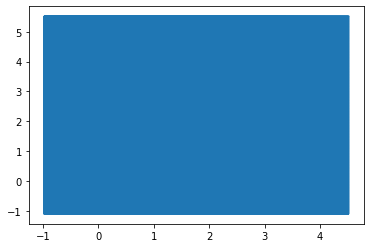

In [ ]:
x_min = np.array(X_std)[:, 0].min() - 0.1 # 计算图的边界
x_max = np.array(X_std)[:, 0].max() + 0.1
y_min = np.array(X_std)[:, 1].min() - 0.1
y_max = np.array(X_std)[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
plt.plot(xx.ravel(), yy.ravel())
plt.show()

In [ ]:
plot_desicion_boundary(X, over_samples_y_train, knn)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


ValueError: ignored

In [ ]:
\]np.array(over_samples_y_train)

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
f, axarr = plt.subplots(1, 1, figsize=(10, 8))
axarr.contourf(xx, yy, Z, alpha = 0.4)
axarr.scatter(np.array(X)[:, 0], np.array(X)[:, 1], c=y, s=10, edgecolor='k')
axarr.set_title("KNN (k={})".format(1))
plt.savefig("k={}.png".format(1))
plt.show()

In [ ]:
# 使用 GridSearchCV 进行参数优化
parameters = {
            'n_neighbors':range(2,30,4),
            'weights':['uniform','distance'],
            'p':[1,2]
            }
knn = neighbors.KNeighborsClassifier(algorithm='kd_tree')
grid_search = GridSearchCV(knn, parameters, scoring='roc_auc',cv=5)
grid_search.fit(X_std,over_samples_y_train) 

grid_search.best_estimator_   #查看函数（最优评估）
grid_search.best_score_       #正确率 (accuracy)
grid_search.best_params_      #最佳组合（参数）

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

In [ ]:
knn=neighbors.KNeighborsClassifier(n_neighbors=20,
                                  p=1,weights='distance')
knn.fit(X_std,over_samples_y_train)  
knn.score(X_std,over_samples_y_train)


1.0

In [ ]:
knn.score(X_val_std,y_val)


0.5067489711934157

使用逻辑回归L1和L2正则

In [ ]:
# from sklearn.linear_model import LogisticRegression
# # L1 penalty
# L1_lg = LogisticRegression(penalty='l1', random_state=123, solver="saga", max_iter=1000)
# param_grid = {
#     'tol': [1e-4, 1e-3, 1e-2],
#     'C': [0.4, 0.6, 0.8]
# }
# grid_search = GridSearchCV(L1_lg, param_grid, cv=5)
# grid_search.fit(over_samples_x_train, over_samples_y_train)

# print(grid_search.score(X_val, y_val))
# print(grid_search.best_params_) 
# print(grid_search.best_estimator_)  

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
# l2正则
logit_model_l2 = LogisticRegressionCV(random_state = 0, Cs = [0.1, 0.25, 0.5, 1, 2, 3, 5, 10, 50, 100]).fit(over_samples_x_train, over_samples_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
logit_model_l2.coef_

array([[-1.44629530e-06,  1.22573188e-02,  9.05196223e-03,
         1.11728357e-02,  1.95881251e-02, -4.01339516e-03,
        -1.79599712e-03, -1.94358588e-03,  4.62478454e-02,
         9.73488372e-02,  1.74856512e-03,  2.73466806e-03,
         1.10641897e-02,  6.66015575e-03,  3.07100317e-03,
         4.44270860e-03, -4.13048225e-03,  2.46207223e-03,
         8.43270507e-04, -1.90032795e-03,  1.48637080e-02,
         3.51244804e-02, -6.34930515e-03, -8.05574114e-03,
        -2.29411329e-02, -3.80312090e-03, -6.47099715e-04,
        -3.09968740e-02,  1.03643700e-02,  9.50851986e-03,
        -1.13263114e-02, -2.35975550e-03,  1.25905338e-02,
        -3.72263913e-03,  1.12573190e-02,  4.64116750e-03,
        -8.45144475e-04,  1.22599838e-03,  4.24642044e-03,
         2.25426645e-03,  4.17202357e-03, -1.64855647e-04,
         7.99309592e-03, -1.06871238e-03,  8.76558938e-03,
        -2.55999490e-03,  1.16339034e-02, -5.83612915e-04,
         9.87431499e-03, -9.59954937e-03, -6.54052973e-0

In [ ]:
train_pred_l2 = logit_model_l2.predict_proba(over_samples_x_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(over_samples_y_train, train_pred_l2[:,1])
train_auc_l2 = auc(false_positive_rate, true_positive_rate)
train_auc_l2

0.6476307932248571

In [ ]:
val_pred_l2 = logit_model_l2.predict_proba(X_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, val_pred_l2[:,1])
val_auc_l2 = auc(false_positive_rate, true_positive_rate)
val_auc_l2

0.6261846280967163

In [ ]:
# l1正则
logit_model_l1 = LogisticRegressionCV(random_state = 0, penalty = "l1", solver = "saga", Cs = [0.1, 0.25, 0.5, 1, 2, 3, 5, 10, 50, 100], max_iter = 500).fit(over_samples_x_train, over_samples_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

In [ ]:
train_pred_l1 = logit_model_l1.predict_proba(over_samples_x_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(over_samples_y_train, train_pred_l1[:,1])
train_auc_l1 = auc(false_positive_rate, true_positive_rate)
train_auc_l1

0.6384406557015585

In [ ]:
val_pred_l1 = logit_model_l1.predict_proba(X_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, val_pred_l1[:,1])
val_auc_l1 = auc(false_positive_rate, true_positive_rate)
val_auc_l1

0.6174936764035343

In [ ]:
# lasso ridge明显欠拟合啊 选择更复杂一些的模型

0.7033002925898757


Text(0.5, 0, 'FPR')

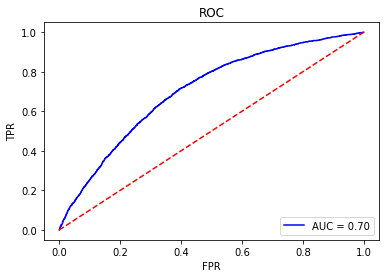

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
parameters = {"max_depth":range(2, 7), "min_samples_leaf": range(5, 55, 10),
              "max_samples":[0.1, 0.15, 0.2],
              "n_estimators": [100, 150, 200, 250]}
              
rf_model = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, scoring = "roc_auc")
best_model = rf_model.fit(over_samples_x_train, over_samples_y_train)
predict_proba = best_model.predict_proba(X_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, predict_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')

In [ ]:
roc_auc

NameError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2',random_state=123, solver='saga').fit(X,y)

In [ ]:
sorted_idx = rf_model.feature_importances_.argsort()

In [ ]:
plt.figure(figsize=(25,20))
plt.barh(X.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
#简单调参
from xgboost import XGBClassifier as XGBC 
xgboost_model = XGBC()
#三个最重要的参数：树的数目、树的深度和学习率
params = {
        'n_estimators':range(50,100,50),
        'max_depth':range(3,9,2),
        'learning_rate':np.linspace(0.01,0.1,10),
        'n_jobs':[1],
        'verbosity':[2],
        'tree_method':['gpu_hist']
        }
grid_search=GridSearchCV(xgboost_model,param_grid=params,cv=5,verbose=2, n_jobs=-1, scoring='roc_auc')
grid_search.fit(over_samples_x_train,over_samples_y_train)
grid_search.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: ignored

In [ ]:
XGB = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,

    verbosity=2,
    objective='binary:logistic',
    njobs=-1,

    gamma=0,
    reg_alpha=0,
    reg_lambda=1,

    subsample=0.8,
    colsample_bytree=0.8
).fit(over_samples_x_train, over_samples_y_train)

[22:00:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22:00:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22:00:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22:00:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22:00:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22:00:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22:00:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[22:00:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nod

In [ ]:
XGB.score(X_val, y_val)


0.746008230452675

In [ ]:
XGB.score(over_samples_x_train, over_samples_y_train)


0.8316504497888746

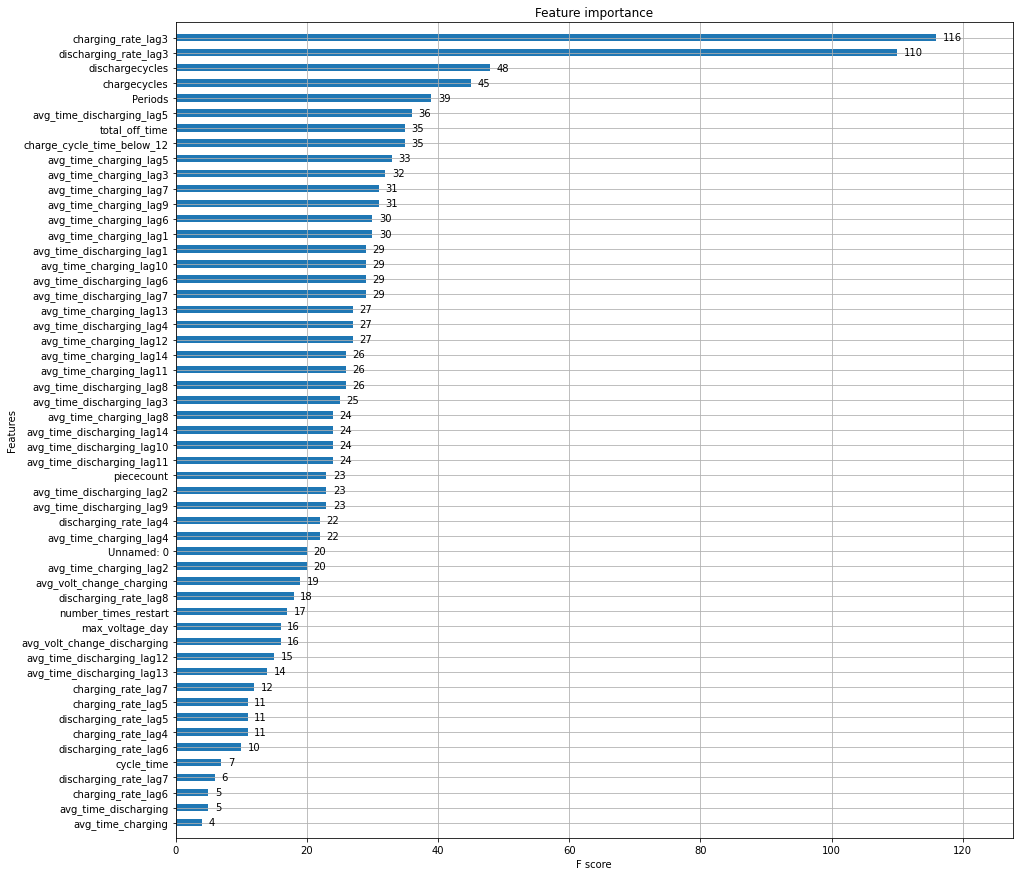

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(XGB,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()

In [ ]:
print(metrics.classification_report(y_val, predicted))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      9311
           1       0.51      0.45      0.48      2839

    accuracy                           0.77     12150
   macro avg       0.67      0.66      0.66     12150
weighted avg       0.76      0.77      0.76     12150



In [ ]:
y_val.value_counts()

0    9311
1    2839
Name: fail_7, dtype: int64